In [ ]:
!pip install datasets==2.10.0 --quiet
!pip install noisereduce
!pip install pydub

In [2]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import noisereduce as nr
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import soundfile as sf

import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [3]:
from google.colab import drive

drive.mount('/content/drive/')
dataet_path = './drive/MyDrive/ML_Project_ASR/dataset.zip'
if not os.path.exists('dataset'):
  os.system(f'unzip -qq "{dataet_path}" -d "/content/"')

Mounted at /content/drive/


In [7]:
dataset_path = '/content/dataset'
# voices_path = '/content/dataset/voices'
os.chdir(dataset_path)

In [ ]:
transcripts = pd.read_csv('dataset.csv')
ds = Dataset.from_pandas(transcripts)
transcripts.head()

voice_filename                                         transcript accent  \
0    voice_1.mp3                      چرا این‌‌‌‌طور فکر می‌‌‌‌کنی؟  فارسی   
1    voice_2.mp3    همیشه من و تو راجع به آن با هم صحبت کرده‌‌‌‌ایم  فارسی   
2    voice_3.mp3             دنیا در حال گذار به‌‌‌‌سمت پایداری است  فارسی   
3    voice_4.mp3   شاخصی که باید عملکرد تسلا را با آن اندازه بگیریم  فارسی   
4    voice_5.mp3  باید تعداد واقعاً غیرقابل‌‌‌‌تصوری باتری تولید...  فارسی   

  gender      tone                                   spectrogram_list  \
0   male  question  [[1.9989476e-02 2.2075528e-02 3.9036643e-02 .....   
1   male    normal  [[6.1963396e-03 3.1057531e-02 4.6533640e-02 .....   
2   male    normal  [[1.4272591e-02 6.7051044e-03 1.6188743e-02 .....   
3   male    normal  [[2.7621930e-04 1.6575218e-04 4.0813102e-04 .....   
4   male    normal  [[4.8780614e-03 2.0332460e-03 3.2056181e-04 .....   

                                          mfccs_list  
0  [[-6.21151978e+02 -4.84527344e+02 -3.68490845e...  
1  [[-5.5206921e+02 -4.6659741e+02 -4.0939148e+02...  
2  [[-509.9545    -431.5223    -407.37778   ... -...  
3  [[-5.8812506e+02 -5.3064386e+02 -4.9151328e+02...  
4  [[-687.66187   -715.71783   -737.44727   ... -...

## Preprocessing:

* Unify labels

In [ ]:
transcripts['gender'].unique()

array(['male', 'female', 'Female', 'مرد', 'male '], dtype=object)

In [13]:
gender = transcripts['gender']
gender.replace(['مرد', 'male '], 'male', inplace=True)
gender.replace('Female', 'female', inplace=True)
transcripts['gender'].unique()

array(['male', 'female'], dtype=object)

In [10]:
print('before:',transcripts['accent'].unique())
accent = transcripts['accent']
accent.replace(['فارسی ', 'farsi'], 'فارسی', inplace=True)
print('after: ',transcripts['accent'].unique())

before: ['فارسی' 'شیرازی' 'farsi' 'فارسی ' 'ترکی' 'خراسانی' 'یزدی']
after:  ['فارسی' 'شیرازی' 'ترکی' 'خراسانی' 'یزدی']


In [11]:
print('before:',transcripts['tone'].unique())
tone = transcripts['tone']
tone.replace(['normal ', 'nortmal', 'nomal', 'Normal'], 'normal', inplace=True)
tone.replace(['Question', 'quenstion', 'question ', 'question/incomplete'], 'question', inplace=True)
tone.replace(['incomplete ', 'incomplet'], 'incomplete', inplace=True)
tone.replace(['exclamatory ', 'exclamative'], 'exclamatory', inplace=True)
tone.replace(['impreative', 'imperative '], 'imperative', inplace=True)
print('after: ',transcripts['tone'].unique())

before: ['question' 'normal' 'imperative' 'incomplete' 'exclamatory' 'normal '
 'question ' 'imperative ' 'exclamatory ' 'incomplet' 'Normal' 'Question'
 'nomal' 'question/incomplete' 'incomplete ' 'exclamative' 'quenstion'
 'nortmal' 'impreative']
after:  ['question' 'normal' 'imperative' 'incomplete' 'exclamatory']


* Reduce noise

In [ ]:
sample_rate = 16000

def reduce_noise(audio_path,sample_rate=16000):
    # Load audio
    audio, rate = librosa.load(audio_path, sr=sample_rate)
    # noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=rate)
    return reduced_noise_audio, rate

* silence trimming

In [ ]:
def remove_silence(audio_path, silence_thresh=-70, chunk_size=100):
    audio = AudioSegment.from_file(audio_path)
    nonsilent_parts = detect_nonsilent(audio, min_silence_len=chunk_size, silence_thresh=silence_thresh)
    if len(nonsilent_parts) == 0:
        return
    trimmed_audio = audio[nonsilent_parts[0][0]:nonsilent_parts[-1][-1]]
    trimmed_audio.export(f"./trimmed_voices/{file_name}", format="mp3")

In [ ]:
os.makedirs('trimmed_voices')
os.makedirs('free_noise')
for i, file_name in enumerate(os.listdir('./voices')):
    print(f'\r[{i}] Trimmimg {file_name} ',end='')
    audio, sr = reduce_noise(f"./voices/{file_name}")
    sf.write(f"./free_noise/{file_name}", audio, samplerate=sr)
    print(f'.',end='')
    remove_silence(f'./free_noise/{file_name}')

[6041] Trimmimg voice_5721.mp3 .

In [ ]:
!zip -r clean_dataset.zip /content/dataset/trimmed_voices
!cp clean_dataset.zip /content/drive/MyDrive/ML_Project_ASR/clean_dataset.zip

In [ ]:
!zip -r free_noise.zip /content/dataset/free_noise
!cp free_noise.zip /content/drive/MyDrive/ML_Project_ASR/free_noise.zip

## Extract MFCC and Spectrogram features

In [ ]:
def extract_features(audio, sr):
    # Compute Spectrogram
    stft = librosa.stft(audio)
    spectrogram = np.abs(stft)
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return spectrogram, mfccs

def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time')
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('Hz')
    plt.xlabel('Time')
    plt.show()

def plot_mfccs(mfccs):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.ylabel('MFCC')
    plt.xlabel('Time')
    plt.show()

## Plot Heatmap

* Plot raw voice features

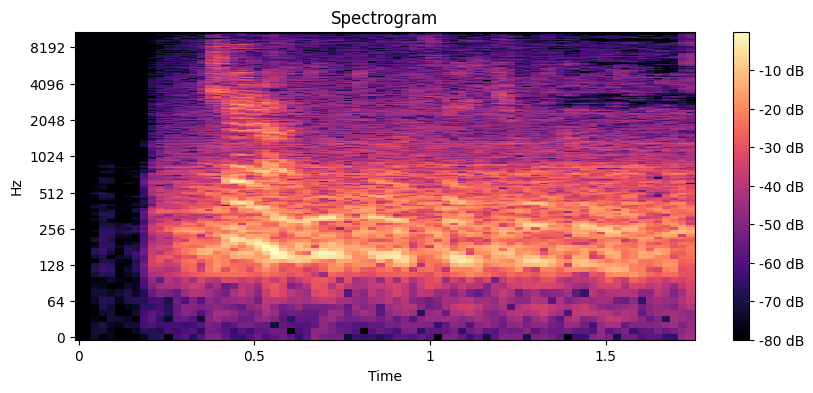

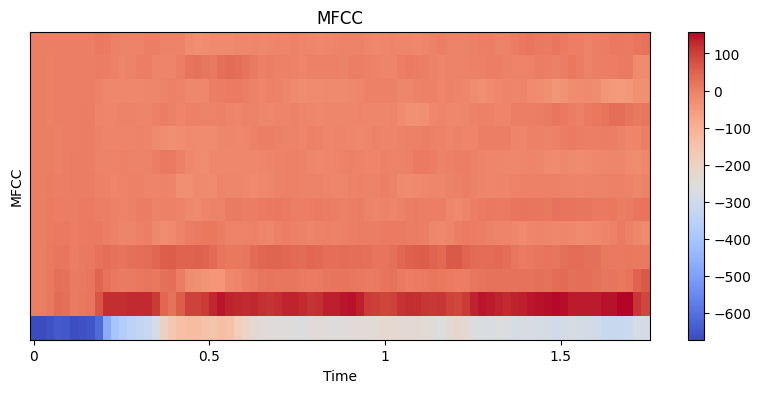

In [ ]:
audio, sr = librosa.load('./voices/voice_1.mp3',sample_rate)
spectrogram, mfccs = extract_features(audio, sr)

plot_spectrogram(spectrogram)
plot_mfccs(mfccs)

* Plot trimmed voice features

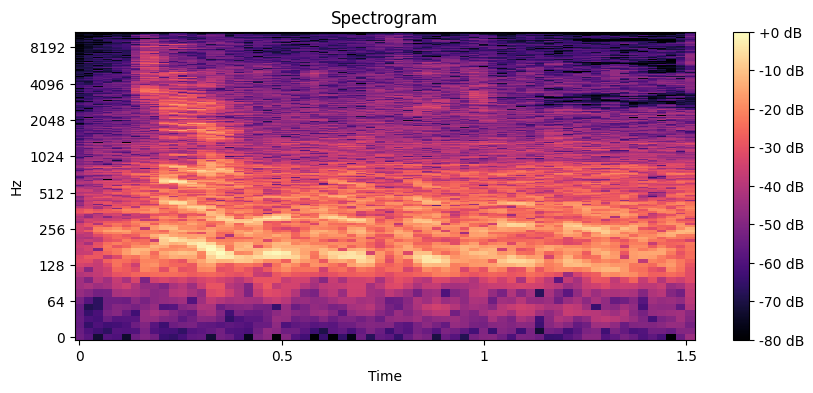

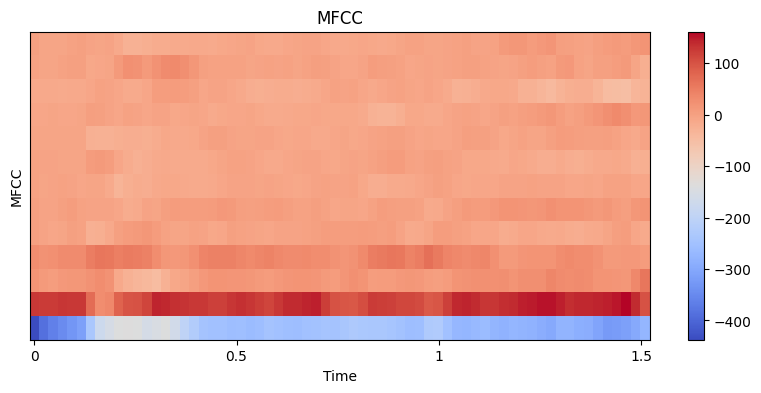

In [ ]:
audio, sr = librosa.load('./trimmed_voices/voice_1.mp3',sample_rate)
spectrogram, mfccs = extract_features(audio, sr)

plot_spectrogram(spectrogram)
plot_mfccs(mfccs)

* Plot trimmed free noise voice features

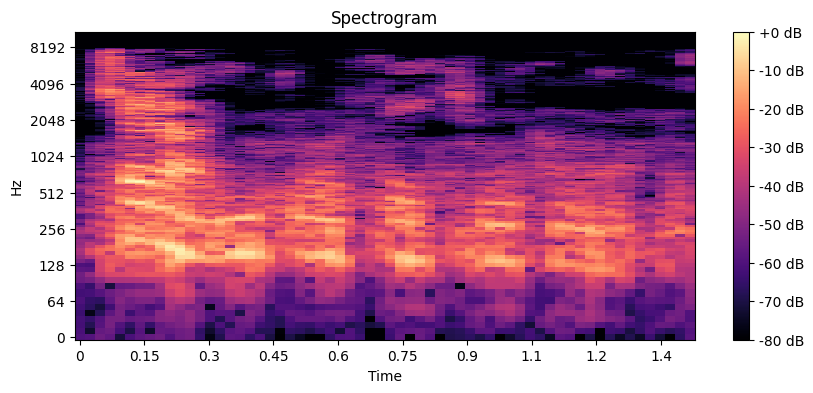

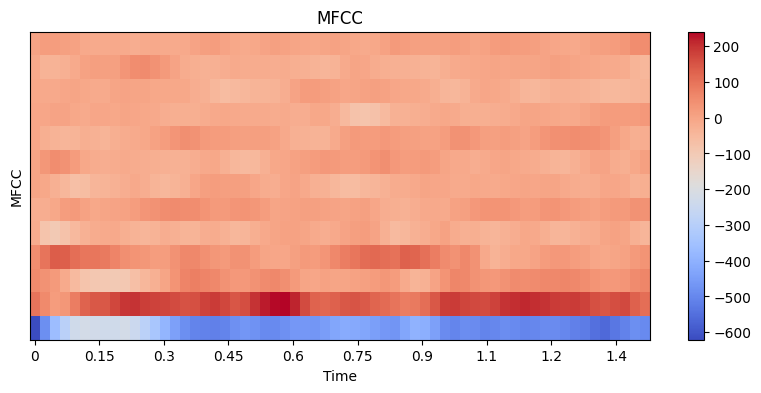

In [ ]:
audio, sr = librosa.load('./trimmed_voices/voice_1.mp3',sample_rate)
spectrogram, mfccs = extract_features(audio, sr)

plot_spectrogram(spectrogram)
plot_mfccs(mfccs)

In [ ]:
print(spectrogram.shape)
print(mfccs.shape)

(1025, 62)
(13, 62)


## Save Extracted features

In [ ]:
spectrogram_list, mfccs_list = [], []
for i in range(len(transcripts)):
    audio, sr = librosa.load(f'./trimmed_voices/voice_{i+1}.mp3', sr=sample_rate)
    spectrogram, mfccs = extract_features(audio, sr)
    print(f'\r[{i}] spectrogram: {len(spectrogram)}, mfccs: {len(mfccs)}',end='')
    spectrogram_list.append(spectrogram)
    mfccs_list.append(mfccs)

[6041] spectrogram: 1025, mfccs: 13

In [ ]:
transcripts['spectrogram']=spectrogram_list
transcripts['mfccs']=mfccs_list

In [ ]:
with open('spectrograms.npy', 'wb') as f:
    np.save(f, transcripts['spectrogram'].to_numpy())

In [ ]:
with open('mfccs.npy', 'wb') as f:
    np.save(f, transcripts['mfccs'].to_numpy())

In [ ]:
!cp /content/dataset/spectrograms.npy /content/drive/MyDrive/ML_Project_ASR/spectrograms.npy
!cp /content/dataset/mfccs.npy /content/drive/MyDrive/ML_Project_ASR/mfccs.npy

In [ ]:
transcripts

voice_filename                                         transcript  \
0        voice_1.mp3                      چرا این‌‌‌‌طور فکر می‌‌‌‌کنی؟   
1        voice_2.mp3    همیشه من و تو راجع به آن با هم صحبت کرده‌‌‌‌ایم   
2        voice_3.mp3             دنیا در حال گذار به‌‌‌‌سمت پایداری است   
3        voice_4.mp3   شاخصی که باید عملکرد تسلا را با آن اندازه بگیریم   
4        voice_5.mp3  باید تعداد واقعاً غیرقابل‌‌‌‌تصوری باتری تولید...   
...              ...                                                ...   
6037  voice_6038.mp3  تا روی آن بنشیند و آن را گرم نگهدارد تا جوجه ب...   
6038  voice_6039.mp3  یک روز تخم شکست و جوجه عقاب از آن بیرون آمد. ج...   
6039  voice_6040.mp3  و طولی نکشید که جوجه عقاب باور کرد که چیزی جز ...   
6040  voice_6041.mp3  او زندگی و خانواده‌اش را دوست داشت اما چیزی از...   
6041  voice_6042.mp3      تا این که یک روز که داشت در مزرعه بازی می کرد   

      accent gender      tone  \
0      فارسی   male  question   
1      فارسی   male    normal   
2      فارسی   male    normal   
3      فارسی   male    normal   
4      فارسی   male    normal   
...      ...    ...       ...   
6037  فارسی    male    normal   
6038  فارسی    male    normal   
6039  فارسی    male    normal   
6040  فارسی    male    normal   
6041  فارسی    male    normal   

                                       spectrogram_list  \
0     [[1.9989476e-02 2.2075528e-02 3.9036643e-02 .....   
1     [[6.1963396e-03 3.1057531e-02 4.6533640e-02 .....   
2     [[1.4272591e-02 6.7051044e-03 1.6188743e-02 .....   
3     [[2.7621930e-04 1.6575218e-04 4.0813102e-04 .....   
4     [[4.8780614e-03 2.0332460e-03 3.2056181e-04 .....   
...                                                 ...   
6037  [[5.5687700e-04 1.6837629e-03 2.5026391e-03 .....   
6038  [[3.1909458e-02 1.4139387e-02 5.5141179e-03 .....   
6039  [[1.22812930e-02 7.47287340e-05 6.99680578e-03...   
6040  [[4.64113280e-02 2.76926085e-02 1.42976614e-02...   
6041  [[7.6372591e-03 4.3366565e-03 5.9585139e-04 .....   

                                             mfccs_list  
0     [[-6.21151978e+02 -4.84527344e+02 -3.68490845e...  
1     [[-5.5206921e+02 -4.6659741e+02 -4.0939148e+02...  
2     [[-509.9545    -431.5223    -407.37778   ... -...  
3     [[-5.8812506e+02 -5.3064386e+02 -4.9151328e+02...  
4     [[-687.66187   -715.71783   -737.44727   ... -...  
...                                                 ...  
6037  [[-6.19354187e+02 -6.15033691e+02 -6.23213623e...  
6038  [[-5.90778931e+02 -6.15590210e+02 -6.21763428e...  
6039  [[-453.90878   -327.21753   -256.37228   ... -...  
6040  [[-538.06433   -504.68607   -490.89713   ... -...  
6041  [[-5.3948187e+02 -5.7618768e+02 -6.2082483e+02...  

[6042 rows x 7 columns]

In [14]:
transcripts.to_csv('/content/dataset/clean_dataset.csv', index=False, encoding='utf-8')

In [ ]:
!cp /content/clean_dataset.csv /content/drive/MyDrive/ML_Project_ASR/clean_dataset.csv

In [ ]:
transcripts = pd.read_csv('/content/clean_dataset.csv')

In [ ]:
for i, file_name in enumerate(os.listdir('./dataset/trimmed_voices')):
    audio, _ = librosa.load(f'dataset/trimmed_voices/{file_name}', sr=sample_rate)

In [ ]:
mfccs_list = np.load('mfccs.npy',allow_pickle=True)
spectrograms_list = np.load('spectrograms.npy',allow_pickle=True)

In [ ]:
!zip -r clean_dataset.zip /content/dataset
!cp clean_dataset.zip /content/drive/MyDrive/ML_Project_ASR/trimmed_dataset.zip